In [30]:
import eons
import neuro
import risp
import speech2spikes
import os
import torchaudio
import torch
import random
import matplotlib.pyplot as plt
import numpy as np
import multiprocessing
import time
import functools

PATH_GUNSHOT_SOUNDS = '/home/joao/dev/MLAudio/shotspotter/data/gunshots'
PATH_NOGUNSHOT_SOUNDS = '/home/joao/dev/MLAudio/shotspotter/data/genBackgrounds'

# Look into possible enabling cumsum (see github)
s2s = speech2spikes.S2S()

# workaround to configure to 12khz sample rate (s2s.configure() didnt work)
s2s._default_spec_kwargs = {
    "sample_rate": 12000,
    "n_mels": 20,
    "n_fft": 512,
    "f_min": 20,
    "f_max": 4000,
    "hop_length": 80,
}
s2s.transform = torchaudio.transforms.MelSpectrogram(**s2s._default_spec_kwargs)

# Some constants
NUM_INPUT_NEURONS = 80 # see paper
NUM_OUTPUT_NEURONS = 2
NUM_SYNAPSES = 1000
NUM_HIDDEN_NEURONS = 250
POP_SIZE = 70

MOA = neuro.MOA()
MOA.seed(23456789, '')

DATASET_CAP = 2000

NUM_PROCESSES = 6

In [2]:
gunshot_file_paths = [PATH_GUNSHOT_SOUNDS+'/'+fn for fn in os.listdir(PATH_GUNSHOT_SOUNDS)][:DATASET_CAP//2]
print(f'We have {len(gunshot_file_paths)} gunshot audio files')
nogunshot_file_paths = [PATH_NOGUNSHOT_SOUNDS+'/'+fn for fn in os.listdir(PATH_NOGUNSHOT_SOUNDS)][:DATASET_CAP//2]
print(f'We have {len(nogunshot_file_paths)} background only audio files')

We have 1000 gunshot audio files
We have 1000 background only audio files


In [3]:
# we want to convert our sound file into spikes
# WARNING: this is VERY bad, bc we save spikes that have values of 0, want to skip these (do later)
def to_spikes(paths_list, labels):
    data = []
    for p in paths_list:
        samples, rate = torchaudio.load(p)
        data.append(samples)

    trains, targets = s2s([(data[i], torch.tensor(labels[i])) for i in range(len(paths_list))])
    #print(trains.shape)

    # LOOK INTO EXACTLY WHAT CUMSUM IS DOING so we can figure out conversion to spikes
    # with cumsum=False (default) looks like it makes sense
    # I think we dont want cumsum (not entirely sure of what its doing)

    #print(trains[0][0])

    all_spikes = []

    for train in trains:
        spikes = []
        spike_id_count = 0
        for i in range(2):
            for channel in train[i]:
                pos_channel, neg_channel = [], []
                pos_id, neg_id = spike_id_count, spike_id_count+1
                for t in range(len(channel)):
                    if channel[t] == 1:
                        pos_channel.append(neuro.Spike(pos_id, t, 1))
                        #neg_channel.append(neuro.Spike(neg_id, t, 0))
                    elif channel[t] == -1:
                        neg_channel.append(neuro.Spike(neg_id, t, 1))
                        #pos_channel.append(neuro.Spike(pos_id, t, 0))
                    #else:
                        #pos_channel.append(neuro.Spike(pos_id, t, 0))
                        #neg_channel.append(neuro.Spike(neg_id, t, 0))
    
                spikes.append(pos_channel.copy())
                spikes.append(neg_channel.copy())

                spike_id_count += 2

        all_spikes.append(spikes.copy())

    return all_spikes, targets


# debug output of to_spikes
def print_spikes(spks, channel_id):
    # channel id from 0-79
    for i in range(len(spks[1])):
        print(f'{spks[channel_id][i].value:.0f}', end=', ')

In [4]:
# generate spikes
p1 = [(i, 1) for i in gunshot_file_paths]
p2 = [(i, 0) for i in nogunshot_file_paths]

pairs = p1+p2 # path to sound - label tuples
random.shuffle(pairs)

spikes, labels = to_spikes([i[0] for i in pairs], [i[1] for i in pairs])

# training/validation split
cutoff_index = int(DATASET_CAP*0.8)
training_spikes = spikes[0:cutoff_index]
training_labels = labels[0:cutoff_index]

validation_spikes = spikes[cutoff_index:DATASET_CAP]
validation_labels = labels[cutoff_index:DATASET_CAP]

In [18]:
# Configure RISP and EONS
risp_config = {
  "min_weight": -1,
  "max_weight": 1,
  "min_threshold": -1,
  "max_threshold": 1,
  "min_potential": -1,
  "max_delay": 10,
  "discrete": False
}

eons_param = {
    "starting_nodes": NUM_HIDDEN_NEURONS,
    "starting_edges": NUM_SYNAPSES,
    "merge_rate": 0,
    "population_size": POP_SIZE,
    "multi_edges": 0,
    "crossover_rate": 0.9,
    "mutation_rate": 0.9,
    "selection_type": "tournament",
    "tournament_size_factor": 0.1,
    "tournament_best_net_factor": 0.9,
    "random_factor": 0.10,
    "num_mutations": 10,
    "node_mutations": { "Threshold": 1.0 },
    "net_mutations": { },
    "edge_mutations": { "Weight": 0.65 , "Delay": 0.35,  },
    "num_best" : 2,
    "add_node_rate": 0.75,
    "delete_node_rate": 0.25,
    "add_edge_rate": 0.75,
    "delete_edge_rate": 0.25,
    "node_params_rate": 2.5,
    "edge_params_rate": 2.5,
    "net_params_rate" : 0
}

proc = risp.Processor(risp_config)
eons_inst = eons.EONS(eons_param)

In [19]:
# set up template network  (inputs and outputs) for eons
template_net = neuro.Network()
template_net.set_properties(proc.get_network_properties())

for i in range(NUM_INPUT_NEURONS):
    node = template_net.add_node(i)
    node.set("Threshold", 1)
    template_net.add_input(i)

for i in range(NUM_INPUT_NEURONS, NUM_INPUT_NEURONS+NUM_OUTPUT_NEURONS):
    node = template_net.add_node(i)
    node.set("Threshold", 1)
    template_net.add_output(i)

proc.load_network(template_net)
# track neuron updates
for output_id in template_net.as_json()['Outputs']:
    proc.track_neuron_events(output_id)

In [24]:
# Debugging or other utilities 
def network_details(nw, log_json=False):
    net_json = nw.as_json()

    if log_json:
        print(net_json)
    
    print(f'Network has {len(net_json["Edges"])} synapses and {len(net_json["Nodes"])} neurons')

    # check if all out nodes have an incoming synapse
    out_ids = net_json['Outputs']
    for edge in net_json['Edges']:
        if edge['to'] in out_ids:
            out_ids.remove(edge['to'])

    if len(out_ids) == 0:
        print('All outputs have incoming connections')
    else:
        print(f'Outputs {out_ids} have no incoming connections')

def compute_fitness(net, spikes, labels, display_per_class=False, reconstruct_spikes=False):
    # Explained in SPECIAL NOTE below, rebuild Spike instances to feed into processor
    if reconstruct_spikes:
        rec_spikes = []

        for i in range(len(spikes)):
            rec_spikes.append([])
            
            for j in range(len(spikes[i])):
                rec_spikes[i].append([])
                
                for active_spike in spikes[i][j]:
                    rec_spikes[i][j].append(neuro.Spike(active_spike[0], active_spike[1], active_spike[2]))

        spikes = rec_spikes
    
    proc.load_network(net)

    correct = 0
    per_class = {0: 0, 1: 0}
    for i in range(len(spikes)):
        proc.clear_activity()

        for c in spikes[i]: # spikes[i] is a single training sample
            proc.apply_spikes(c)

        proc.run(1000)

        out_counts = proc.output_counts()

        prediction = 0 if out_counts[0] > out_counts[1] else 1

        if prediction == labels[i]:
            correct += 1
            per_class[prediction] += 1

    if display_per_class:
        print(f'For class 0: {per_class[0]}/{(labels == 0).sum()}')
        print(f'For class 1: {per_class[1]}/{(labels == 1).sum()}')

    return correct
        

In [25]:
# Training
EPOCH_COUNT = 100
eons_inst.set_template_network(template_net)
pop = eons_inst.generate_population(eons_param, MOA.random_integer())

best_fit_log = []
best_fit_validation_log = []
pop_fit_log = [] # mean
TRAINING_SET_SIZE = int(DATASET_CAP*0.8)
t0, t1, = 0, 0

In [26]:
# SPECIAL NOTE
# For now we'll turn each spike into a tuple (id, time, value) so we can serialize it for multiprocessing,
# Then we'll reconstruct it in each com
# I'm not sure if we can make neuro.Spike picklable easily since it's in c++
training_spikes_serializable = []
for i in range(len(training_spikes)):
    training_spikes_serializable.append([])
    
    for j in range(len(training_spikes[i])): # channel index
        training_spikes_serializable[i].append([])
        
        for active_spike in training_spikes[i][j]:
            training_spikes_serializable[i][j].append((active_spike.id, active_spike.time, active_spike.value))

In [ ]:
for i in range(EPOCH_COUNT):
    print(f'Starting epoch {i}...')
    t0 = time.time()

    compute_fitness_partial = functools.partial(compute_fitness, spikes=training_spikes_serializable, labels=training_labels, reconstruct_spikes=True)
    with multiprocessing.Pool(processes=NUM_PROCESSES) as p:
        fits = p.map(compute_fitness_partial, 
                    [n.network for n in pop.networks])

    best_fit_log.append(max(fits)/TRAINING_SET_SIZE)
    pop_fit_log.append((sum(fits)/len(fits))/TRAINING_SET_SIZE)

    print(f'Best accuracy: {best_fit_log[-1]*100:.2f}')

    best_net = pop.networks[fits.index(max(fits))].network
    network_details(best_net)

    # try it on validation set samples
    validation_fit = compute_fitness(best_net, validation_spikes, validation_labels, display_per_class=True)
    best_fit_validation_log.append(validation_fit)
    print(f'Validation set accuracy for best network: {validation_fit/(DATASET_CAP-TRAINING_SET_SIZE):.2f}')

    print(f'This epoch took {time.time()-t0:.2f} to run')
    print('----------')
    pop = eons_inst.do_epoch(pop, fits, eons_param)

Starting epoch 0...
Best accuracy: 61.62
Network has 1040 synapses and 337 neurons
All outputs have incoming connections
For class 0: 123/202
For class 1: 125/198
Validation set accuracy for best network: 0.62
This epoch took 146.81 to run
----------
Starting epoch 1...
Best accuracy: 62.25
Network has 1034 synapses and 335 neurons
All outputs have incoming connections
For class 0: 153/202
For class 1: 76/198
Validation set accuracy for best network: 0.57
This epoch took 130.31 to run
----------
Starting epoch 2...
Best accuracy: 62.25
Network has 1034 synapses and 335 neurons
All outputs have incoming connections
For class 0: 153/202
For class 1: 76/198
Validation set accuracy for best network: 0.57
This epoch took 139.33 to run
----------
Starting epoch 3...
Best accuracy: 63.25
Network has 1035 synapses and 337 neurons
All outputs have incoming connections
For class 0: 137/202
For class 1: 108/198
Validation set accuracy for best network: 0.61
This epoch took 134.62 to run
---------

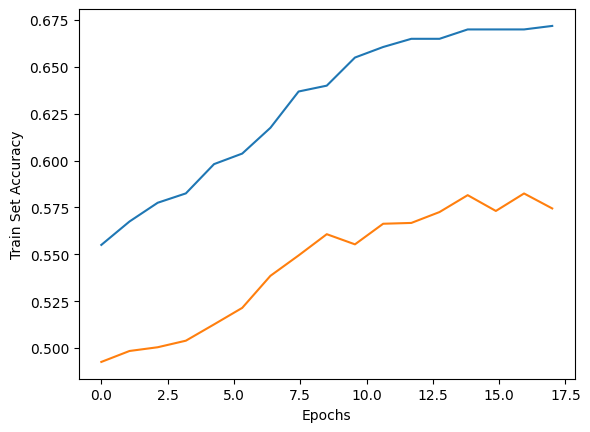

In [15]:
plt.ylabel('Train Set Accuracy')
plt.xlabel('Epochs')

plt.plot(np.linspace(0, len(best_fit_log), len(best_fit_log)), best_fit_log)
plt.plot(np.linspace(0, len(pop_fit_log), len(pop_fit_log)), pop_fit_log)

In [14]:
# TODO: add mechanism to save current best performer on validation set 

This epoch took 545.42 to run


In [16]:
neuro.Spike()

TypeError: __init__(): incompatible constructor arguments. The following argument types are supported:
    1. neuro.Spike(id: int, time: float, value: float)

Invoked with: 